In [3]:
import torch
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer.backends.qasm_simulator import QasmSimulator
from qiskit.providers.aer import AerSimulator
import qiskit.quantum_info as qi
import torch.distributions.normal as Normal
from tqdm import tqdm
from scipy.stats import norm
import matplotlib.pyplot as plt
from typing import Union
import csv

import torch.distributions.normal as Normal
import torch.optim as optim

from qiskit import QuantumCircuit
from qiskit.providers.aer import AerSimulator
import qiskit.quantum_info as qi

In [4]:
def perform_action(amp: Union[torch.Tensor, np.array], shots=1, target_state="|1>", epoch=1):
    """
    Execute quantum circuit with parametrized amplitude, retrieve measurement result and assign rewards accordingly
    :param amp: amplitude parameter, provided as an array of size batchsize
    :param shots: number of evaluations to be done on the quantum computer (for simplicity stays to 1)
    :param target_state: String indicating which target state is intended (can currently only be "|1>" or "|->")
    :return: Reward table (reward for each run in the batch)
    """
    global qc, qasm, tgt_string  # Use the same quantum circuit instance to be reset after each run
    angles, batch = np.array(amp), len(np.array(amp))
    density_matrix = np.zeros([2, 2], dtype='complex128')
    reward_table = np.zeros(batch)

    for j, angle in enumerate(angles):
        if tgt_string == "|1>":
            qc.rx(2 * np.pi * angle, 0)  # Add parametrized gate for each amplitude in the batch
            q_state = qi.Statevector.from_instruction(qc)
            density_matrix += np.array(
                q_state.to_operator()) / batch  # Build density matrix as a statistical mixture of
            # states created by the different actions
        elif tgt_string == "|+>":
            qc.ry(2 * np.pi * angle, 0)  # Add parametrized gate for each amplitude in the batch
            q_state = qi.Statevector.from_instruction(qc)
            density_matrix += np.array(q_state.to_operator()) / batch  # Build density matrix as a statistical mixture
            # of states created by the different actions
            qc.h(0)  # Rotate qubit for measurement in the Hadamard basis

        qc.measure(0, 0)  # Measure the qubit

        job = qasm.run(qc, shots=shots)
        result = job.result()
        counts = result.get_counts(qc)  # Returns a dictionary with keys '0' and '1' with the number of counts for each key

        #  Calculate reward (Generalized to include any number of shots for each action)
        if tgt_string == "|1>":
            reward_table[j] += np.mean(np.array([1] * counts.get('1', 0) + [-1] * counts.get('0', 0)))
        elif tgt_string == "|+>":
            reward_table[j] += np.mean(np.array([1] * counts.get('0', 0) + [-1] * counts.get('1', 0)))
        qc.clear()  # Reset the Quantum Circuit for the next iteration

    return reward_table, qi.DensityMatrix(density_matrix)  # reward_table is of Shape [batchsize]

In [5]:
# Variables to define environment
qc = QuantumCircuit(1, 1, name="qc")  # Two-level system of interest, 1 qubit
qasm = QasmSimulator(method="statevector")  # Simulation backend (mock quantum computer)

# TODO:: Define a reward function/circuit for each target state in the dictionary
target_states_list = {
    "|1>": qi.DensityMatrix(np.array([[0.], [1.]]) @ np.array([[0., 1.]])),
    "|+>": qi.DensityMatrix(0.5 * np.array([[1.], [1.]]) @ np.array([[1., 1.]]))
}
tgt_string = "|1>"

# Hyperparameters for the agent
seed = 2364  # Seed for action sampling (ref 2763)


n_epochs = 60
batch_size = 50
use_PPO = True

eta = 0.1  # Learning rate for policy update step
critic_loss_coeff = 0.5

epsilon = 0.2  # Parameter for ratio clipping value (PPO)
grad_clip = 0.3
sigma_eps = 1e-6

In [6]:
# Policy parameters (using torch.nn.Parameter)
mu = torch.nn.Parameter(torch.randn([]) * 0.05, requires_grad=True)
sigma = torch.nn.Parameter(torch.tensor(1.0), requires_grad=True)
mu_old = torch.clone(mu).detach().requires_grad_(False)
sigma_old = torch.clone(sigma).detach().requires_grad_(False)
b = torch.nn.Parameter(torch.tensor(0.0), requires_grad=True)

print('Initial Parameters')
print('-------------------------')
print('\nmu: ', mu.item())
print('sigma: ', sigma.item())
print('b: ', b.item())

optimizer_string = "Adam"
# Define the optimizer based on optimizer_string
if optimizer_string == "Adam":
    optimizer = optim.Adam([mu, sigma, b], lr=eta)
elif optimizer_string == "SGD":
    optimizer = optim.SGD([mu, sigma, b], lr=eta)

Initial Parameters
-------------------------

mu:  -0.04941488057374954
sigma:  1.0
b:  0.0


In [7]:
def constrain_mu(value):
    return torch.clamp(value, -1., +1.)

def constrain_sigma(value):
    return torch.clamp(value, sigma_eps, 1.5)

In [8]:
#  Keep track of variables
data = {
    "means": np.zeros(n_epochs),
    "stds": np.zeros(n_epochs),
    "amps": np.zeros([n_epochs, batch_size]),
    "rewards": np.zeros([n_epochs, batch_size]),
    "critic_loss": np.zeros(n_epochs),
    "fidelity": np.zeros(n_epochs),
    "grads": np.zeros((n_epochs, 3)),
    "hyperparams": {
        "learning_rate": eta,
        "seed": seed,
        "clipping_PPO": epsilon,
        "grad_clip_value": grad_clip,
        "n_epochs": n_epochs,
        "batch_size": batch_size,
        "target_state": (tgt_string, target_states_list[tgt_string]),
        "PPO?": use_PPO,
        "critic_loss_coeff": critic_loss_coeff,
        "optimizer": optimizer_string

    }
}

In [499]:
def log_info(epoch, mu, sigma, reward, target_state, fidelity):
    print('\nEPOCH', epoch+1)
    print('Policy parameter')
    print(f'mu = {mu.item()} +- sigma = {sigma.item()}')
    print('baseline', b.item())
    print('Average Return:', reward.mean().item())
    print('Target state: ', target_state)
    print('Fidelity: ', fidelity)

In [500]:
for epoch in tqdm(range(n_epochs)):
    normal_distrib = Normal.Normal(mu, sigma)
    normal_distrib_old = Normal.Normal(mu_old, sigma_old)
    a = normal_distrib.sample((batch_size,))

    # Run quantum circuit to retrieve rewards (in this example, only one time step)
    reward, dm_observed = perform_action(a, shots=1, target_state=tgt_string, epoch=epoch)
    print("Average Return:", reward.mean().item())

    # Assuming you have defined a model for your actor and critic, let's compute the loss and gradients
    # The following code assumes you have a model and an optimizer defined. Here, we're just focusing on the loss calculation.
    optimizer.zero_grad()

    advantage = torch.tensor(reward) - b
    if use_PPO:
        ratio = normal_distrib.log_prob(a).exp() / (normal_distrib_old.log_prob(a).exp() + sigma_eps)
        clipped_ratio = torch.clamp(ratio, 1 - epsilon, 1 + epsilon)
        actor_loss = - torch.mean(torch.min(advantage * ratio, advantage * clipped_ratio))
    else:  # REINFORCE algorithm
        log_probs = normal_distrib.log_prob(a)
        actor_loss = - torch.mean(advantage * log_probs)

    critic_loss = torch.mean(advantage ** 2)

    combined_loss = actor_loss + critic_loss_coeff * critic_loss
    combined_loss.backward()

    # Clipping gradients (if needed)
    torch.nn.utils.clip_grad_norm_([mu, sigma, b], grad_clip)

    # For PPO, update old parameters to have access to "old" policy
    if use_PPO:
        mu_old.data = mu.data.clone()
        sigma_old.data = sigma.data.clone()

    # Apply gradients
    optimizer.step()

    data["amps"][epoch] = np.array(a.cpu().detach())
    data["rewards"][epoch] = reward
    data["means"][epoch] = np.array(mu.item())
    data["stds"][epoch] = np.array(sigma.item())
    data["critic_loss"][epoch] = np.array(critic_loss.cpu().detach())
    data["fidelity"][epoch] = qi.state_fidelity(target_states_list[tgt_string], dm_observed)
    data["grads"][epoch] = np.array([param.grad for param in [mu, sigma, b]])

    # Log intermediate results of the training process
    if epoch % 10 == 0:
        log_info(epoch, mu, sigma, reward, tgt_string, data["fidelity"][epoch])

  8%|▊         | 5/60 [00:00<00:01, 40.75it/s]

Average Return: -0.28

EPOCH 1
Policy parameter
mu = 0.10453199595212936 +- sigma = 1.0999997854232788
baseline -0.10000000149011612
Average Return: -0.28
Target state:  |1>
Fidelity:  0.4417885974329157
Average Return: -0.04
Average Return: 0.0
Average Return: -0.04
Average Return: -0.04
Average Return: -0.12
Average Return: 0.04
Average Return: -0.04
Average Return: -0.12
Average Return: -0.08


 28%|██▊       | 17/60 [00:00<00:00, 52.10it/s]

Average Return: 0.28

EPOCH 11
Policy parameter
mu = -0.11437229812145233 +- sigma = 0.8147304058074951
baseline -1.0612391233444214
Average Return: 0.28
Target state:  |1>
Fidelity:  0.5422002916682069
Average Return: 0.44
Average Return: -0.08
Average Return: 0.16
Average Return: 0.0
Average Return: 0.08
Average Return: -0.12
Average Return: 0.08
Average Return: 0.24
Average Return: -0.08
Average Return: 0.2

EPOCH 21
Policy parameter
mu = -0.3667762279510498 +- sigma = 0.2882556617259979
baseline -1.1703397035598755
Average Return: 0.2
Target state:  |1>
Fidelity:  0.5476738804945918
Average Return: -0.12


 48%|████▊     | 29/60 [00:00<00:00, 55.20it/s]

Average Return: 0.4
Average Return: 0.6
Average Return: 0.6
Average Return: 0.64
Average Return: 0.96
Average Return: 0.76
Average Return: 0.92
Average Return: 0.96
Average Return: 0.8

EPOCH 31
Policy parameter
mu = -0.5720236897468567 +- sigma = 0.013772470876574516
baseline -0.8641559481620789
Average Return: 0.8
Target state:  |1>
Fidelity:  0.9389164047607798
Average Return: 0.76
Average Return: 0.92
Average Return: 0.96


 68%|██████▊   | 41/60 [00:00<00:00, 56.84it/s]

Average Return: 0.96
Average Return: 0.84
Average Return: 0.84
Average Return: 0.84
Average Return: 0.84
Average Return: 1.0
Average Return: 0.96

EPOCH 41
Policy parameter
mu = -0.5637935400009155 +- sigma = 0.005481447093188763
baseline -0.669879138469696
Average Return: 0.96
Target state:  |1>
Fidelity:  0.9553221658416234
Average Return: 0.96
Average Return: 0.92
Average Return: 0.96
Average Return: 0.88
Average Return: 1.0


 88%|████████▊ | 53/60 [00:00<00:00, 56.71it/s]

Average Return: 1.0
Average Return: 0.96
Average Return: 0.88
Average Return: 0.96
Average Return: 0.96

EPOCH 51
Policy parameter
mu = -0.5389857888221741 +- sigma = 0.006697364151477814
baseline -0.5829614996910095
Average Return: 0.96
Target state:  |1>
Fidelity:  0.9755598526897761
Average Return: 1.0
Average Return: 0.92
Average Return: 0.96
Average Return: 0.96
Average Return: 1.0
Average Return: 1.0
Average Return: 0.92


100%|██████████| 60/60 [00:01<00:00, 54.89it/s]

Average Return: 1.0
Average Return: 0.92


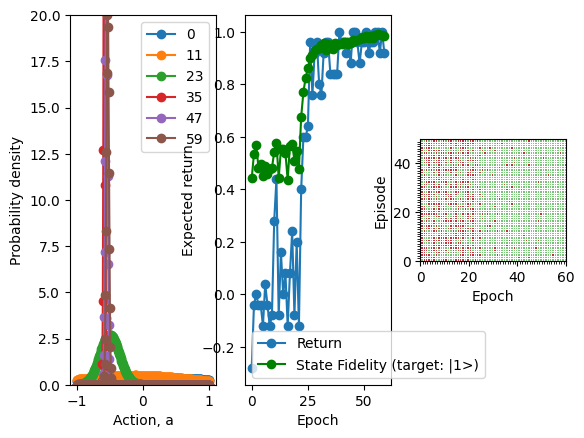

In [502]:
#  Plotting results
def plot_examples(ax, reward_table):
    """
    Helper function to plot data with associated colormap, used for plotting the reward per each epoch and each episode
    (From original repo associated to the paper https://github.com/v-sivak/quantum-control-rl)
    """

    vals = np.where(reward_table == 1, 0.6, -0.9)

    ax.pcolormesh(np.transpose(vals), cmap='RdYlGn', vmin=-1, vmax=1)

    ax.set_xticks(np.arange(0, vals.shape[0], 1), minor=True)
    ax.set_yticks(np.arange(0, vals.shape[1], 1), minor=True)
    ax.grid(which='both', color='w', linestyle='-')
    ax.set_aspect('equal')
    ax.set_ylabel('Episode')
    ax.set_xlabel('Epoch')
    plt.show()


x = np.linspace(-1., 1., 300)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
# Plot probability density associated to updated parameters for a few steps
for i in np.linspace(0, n_epochs-1, 6, dtype=int):
    ax1.plot(x, norm.pdf(x, loc=data["means"][i], scale=np.abs(data["stds"][i])), '-o', label=f'{i}')

ax1.set_xlabel("Action, a")
ax1.set_ylabel("Probability density")
ax1.set_ylim(0., 20)
#  Plot return as a function of epochs
ax2.plot(np.mean(data["rewards"], axis=1), '-o', label='Return')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Expected return")
# ax2.plot(data["critic_loss"], '-.', label='Critic Loss')
ax2.plot(data["fidelity"], '-o', label=f'State Fidelity (target: {tgt_string})', color='green')
ax2.legend()
ax1.legend()
plot_examples(ax3, data["rewards"])

In [507]:
final_mu = data["means"][-1]
final_mu

-0.5326224565505981

In [508]:
final_sigma = np.abs(data["stds"][-1])
final_sigma

0.019034385681152344

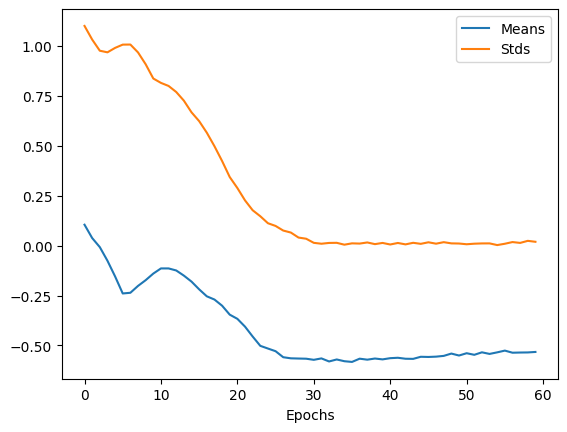

In [509]:
plt.plot(np.arange(0, n_epochs), data["means"], label='Means')
plt.plot(np.arange(0, n_epochs), np.abs(data["stds"]), label='Stds')
plt.xlabel('Epochs')
plt.legend()
plt.show()

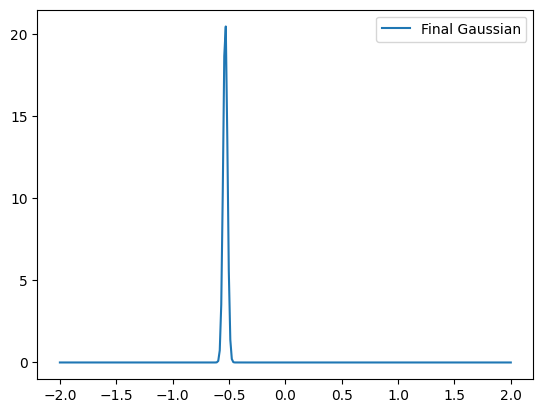

In [511]:
x = np.linspace(-2., 2., 300)
plt.plot(x, norm.pdf(x, loc=final_mu, scale=final_sigma), label='Final Gaussian')
plt.legend()
plt.show()